In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [21]:
def plot_series(time, series, format="-", start=0, end=None):
    
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

In [2]:
raw_data = pd.read_csv("GDP_Dataset.csv")

def extract_last_4_chars(value):
    return value[-4:]

raw_data['date'] = raw_data['date'].apply(extract_last_4_chars)

raw_data["date"] = raw_data["date"].astype(int)

raw_data.replace(np.nan, 0)

print(raw_data)

    date         GDP   Per Capita   Growthannualchange
0   1960    3.749265      81.5869                  NaN
1   1961    4.118648      87.5174               5.9873
2   1962    4.310164      89.4933               4.4829
3   1963    4.630827      93.8839               8.6888
4   1964    5.204956     102.9612               7.5698
..   ...         ...          ...                  ...
58  2018  356.128225    1620.7429               6.1517
59  2019  320.909489    1437.1659               2.4976
60  2020  300.425667    1322.3150              -1.2741
61  2021  348.262545    1505.0102               6.4871
62  2022  414.885900    1579.2250               4.9312

[63 rows x 4 columns]


In [3]:
series = raw_data[" GDP"].values
time = raw_data["date"].values

In [4]:
split_time = 56

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [8]:
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [10]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [11]:
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model_baseline.compile(loss="mse", optimizer=optimizer)

In [13]:
history = model_baseline.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
2/2 [==============================] - 3s 44ms/step - loss: 5104.5562 - lr: 1.0000e-08
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 5034.4229 - lr: 1.1220e-08
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 4886.5020 - lr: 1.2589e-08
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 4652.9575 - lr: 1.4125e-08
Epoch 5/100
2/2 [==============================] - 0s 5ms/step - loss: 4372.1543 - lr: 1.5849e-08
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 4013.1719 - lr: 1.7783e-08
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 3603.8530 - lr: 1.9953e-08
Epoch 8/100
2/2 [==============================] - 0s 5ms/step - loss: 3135.4404 - lr: 2.2387e-08
Epoch 9/100
2/2 [==============================] - 0s 5ms/step - loss: 2720.0029 - lr: 2.5119e-08
Epoch 10/100
2/2 [==============================] - 0s 4ms/step - loss: 2256.8838 - lr: 2.8184e-08
Epoch 11/100
2/2 [

(1e-08, 0.001, 0.0, 300.0)

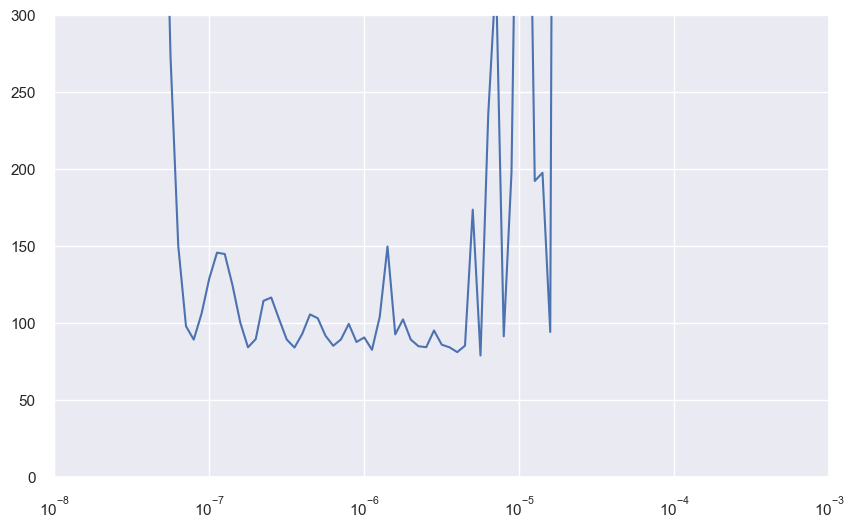

In [14]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))

plt.grid(True)

plt.semilogx(lrs, history.history["loss"])

plt.tick_params('both', length=10, width=1, which='both')

plt.axis([1e-8, 1e-3, 0, 300])

In [15]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=2e-6, momentum=0.9)

In [17]:
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=1000)

Epoch 1/1000
2/2 [==============================] - 0s 19ms/step - loss: 17925.9648
Epoch 2/1000
2/2 [==============================] - 0s 4ms/step - loss: 10780.4961
Epoch 3/1000
2/2 [==============================] - 0s 5ms/step - loss: 5049.4097
Epoch 4/1000
2/2 [==============================] - 0s 4ms/step - loss: 621.3253
Epoch 5/1000
2/2 [==============================] - 0s 4ms/step - loss: 5208.0410
Epoch 6/1000
2/2 [==============================] - 0s 6ms/step - loss: 185.2709
Epoch 7/1000
2/2 [==============================] - 0s 6ms/step - loss: 1554.3593
Epoch 8/1000
2/2 [==============================] - 0s 4ms/step - loss: 572.5520
Epoch 9/1000
2/2 [==============================] - 0s 5ms/step - loss: 438.4215
Epoch 10/1000
2/2 [==============================] - 0s 4ms/step - loss: 1795.7333
Epoch 11/1000
2/2 [==============================] - 0s 6ms/step - loss: 130.2002
Epoch 12/1000
2/2 [==============================] - 0s 5ms/step - loss: 1562.7714
Epoch 13/1000
2

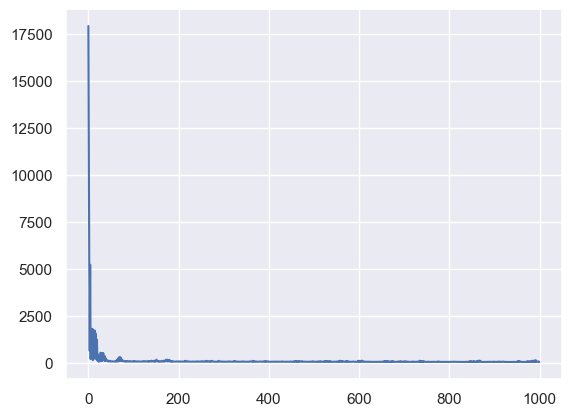

In [18]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

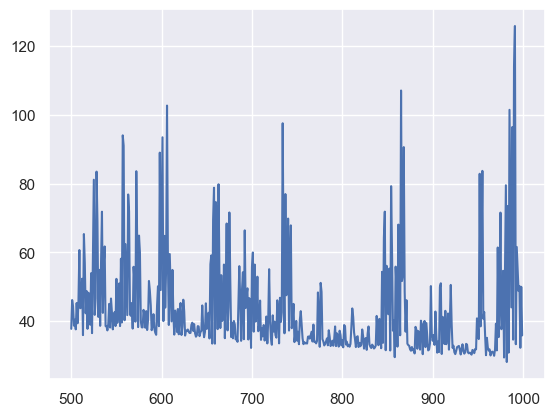

In [20]:
loss = history.history['loss']
epochs = range(500, len(loss))
plot_loss = loss[500:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

1/1 [==============================] - 0s 19ms/step


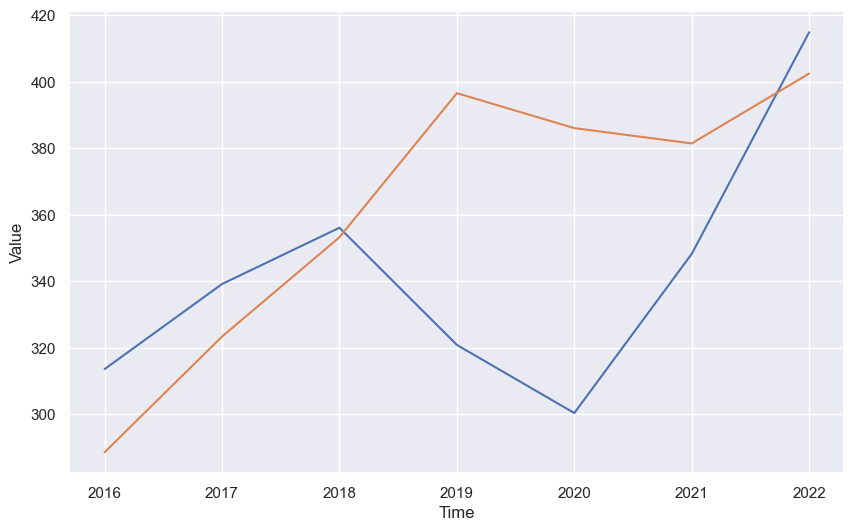

In [22]:
forecast = []
forecast_series = series[split_time - window_size:]

for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

results = np.array(forecast).squeeze()

plot_series(time_valid, (x_valid, results))

In [23]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

2171.103
35.79623
